In [1]:
!pip install tslearn --ignore-installed

     |████████████████████████████████| 374 kB 3.5 MB/s            
     |████████████████████████████████| 302 kB 63.4 MB/s            
     |████████████████████████████████| 24.8 MB 61.9 MB/s            
     |████████████████████████████████| 38.1 MB 65.9 MB/s            
     |████████████████████████████████| 3.5 MB 76.4 MB/s            
     |████████████████████████████████| 15.7 MB 56.2 MB/s            
     |████████████████████████████████| 804 kB 64.1 MB/s            
     |████████████████████████████████| 34.6 MB 29.9 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires goo

In [2]:
import random
import datetime
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import tslearn
from tslearn.shapelets import LearningShapelets

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [3]:
df = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
tot_sequence = len(df.sequence.unique())
tot_subject = len(df.subject.unique())
print(f'We have {tot_sequence} sequences and {tot_subject} subjects.')

df.set_index(['sequence', 'subject'], drop=False, inplace=True)
df.drop('step', axis=1, inplace=True)
df.head()

We have 25968 sequences and 672 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
0        47              0       47  -0.196291   0.112395        1.0   
         47              0       47  -0.447450   0.134454        1.0   
         47              0       47   0.326893  -0.694328        1.0   
         47              0       47   0.523184   0.751050        1.0   
         47              0       47   0.272025   1.074580        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
0        47        0.329204  -1.004660  -0.131638  -0.127505   0.368702   
         47       -0.658407   0.162495   0.340314  -0.209472  -0.867176   
         47        0.330088   0.473678   1.280479  -0.094718   0.535878   
         47        0.976991  -0.563287  -0.720269   0.793260   0.951145   
         47       -0.136283   0.398579   0.044877   0.560109  -0.541985   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
0        47            -0.1  -0.963873  -0.985069   0.531893   4.751492  
         47             0.2  -0.301301   0.082733  -0.231481   0.454390  
         47             1.4   1.002168   0.449221  -0.586420  -4.736147  
         47            -0.3  -0.995665  -0.434290   1.344650   0.429241  
         47            -0.9   1.055636   0.812631   0.123457  -0.223359

In [4]:
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')
tot_sequence_test = len(df_test.sequence.unique())
print(f'We have {tot_sequence_test} sequences and {len(df_test.subject.unique())} subjects.')

df_test.set_index(['sequence', 'subject'], drop=False, inplace=True)
df_test.drop('step', axis=1, inplace=True)
df_test.head()

We have 12218 sequences and 319 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
25968    684         25968      684   2.427357  19.639706        1.0   
         684         25968      684  -4.950541 -21.747899        1.0   
         684         25968      684   1.136012 -10.756303        1.0   
         684         25968      684   0.806028   6.504202        1.0   
         684         25968      684   1.288253   5.552521        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
25968    684      -1.466372  -1.289973  -4.207928   2.486339  -2.493893   
         684       0.983186  -0.569053   1.845924  -3.887978   1.727481   
         684       1.016814   0.964157   2.454749   0.312386   1.154198   
         684      -0.179646   0.969221  -1.035153  -0.457195   0.254962   
         684      -0.493805  -1.036124  -1.126402   2.008197  -0.730534   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
25968    684            8.0  -1.123555  -1.673048  10.980453   0.419011  
         684           -2.9   0.395231  -0.882233  -1.871399  -0.008525  
         684           -5.6   1.114162   1.525273 -11.584362   0.139812  
         684           -2.7  -0.588873   0.608761  -4.241770  -0.462916  
         684            0.0   0.899566  -1.259615  -0.472222  -0.121483

In [5]:
df_label = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
df_label.head(10)

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


## Turn `df` into a 3D matrix

In [6]:
df.drop(['sequence', 'subject'], axis=1, inplace=True)
df_test.drop(['sequence', 'subject'], axis=1, inplace=True)

In [7]:
print(df.shape[1] == df_test.shape[1])

def get_3D(data, total_seq):
    new_data = np.zeros((total_seq, 60, 13))
    for i in range(total_seq):
        new_data[i] = data.loc[i]
    return new_data

def get_3D_test(data, total_seq):
    new_data = np.zeros((total_seq, 60, 13))
    for i in range(total_seq):
        # in test dataset, the index starts 25968, which is
        # the total sequence (tot_sequence) in the train dataset.
        new_data[i] = data.loc[i + tot_sequence]
    return new_data

True


In [8]:
df_3d = get_3D(df, tot_sequence)
df_test_3d = get_3D_test(df_test, tot_sequence_test)

In [9]:
print(df_3d.shape)
print(df_test_3d.shape)

(25968, 60, 13)
(12218, 60, 13)


### and split the dataset into train and valid

In [10]:
rnd = np.random.default_rng(8)
trainid = rnd.choice(tot_sequence, replace=False, size=int(0.8*tot_sequence))
validid = [i for i in list(range(tot_sequence)) if i not in trainid]

In [11]:
# the sequences are splitted perfectly into 2 groups
set(trainid).intersection(set(validid))

set()

In [12]:
train_X = df_3d[trainid, :]
valid_X = df_3d[validid, :]

train_y = df_label.loc[trainid, 'state']
valid_y = df_label.loc[validid, 'state']

In [13]:
train_X.shape

(20774, 60, 13)

In [14]:
valid_X.shape

(5194, 60, 13)

# Shapelet transformation

* I only use 30% of the train dataset to learn the shapelets.
* I train all 13 sensors at once

In [15]:
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

# get a dictionary of how many shapelets (value) to be found for each shapelet length (key)
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts=int(0.3*len(trainid)), ts_sz=60, n_classes=2, l=0.15, r=5)
shapelet_dict

{9: 5, 18: 5, 27: 5, 36: 5, 45: 4}

In [16]:
random.seed(99)
# we're taking only 30% of the train dataset
PERCENTAGE = 0.3
train_sequence_we_want = random.sample(set(trainid), k=int(PERCENTAGE*len(trainid)))

# but the 3D train dataset is in ndarray, so there must be some sequence numbers which are bigger than the 3D matrix size
# so, we need to take True and False for each data
train_or_no = np.isin(trainid, train_sequence_we_want)


# make the shapelet learner class and fit
trans = LearningShapelets(weight_regularizer=0.001, batch_size=512, max_iter=5000, total_lengths=5,
                          optimizer='Adam', scale=True, verbose=2)

print(datetime.datetime.now().time())
trans.fit(train_X[train_or_no, :, :], train_y[train_or_no])
print(datetime.datetime.now().time())

06:13:22.073556
Epoch 1/5000
13/13 - 22s - loss: 0.6884 - binary_accuracy: 0.5069 - binary_crossentropy: 0.6865
Epoch 2/5000
13/13 - 0s - loss: 0.6812 - binary_accuracy: 0.5071 - binary_crossentropy: 0.6793
Epoch 3/5000
13/13 - 0s - loss: 0.6752 - binary_accuracy: 0.5170 - binary_crossentropy: 0.6733
Epoch 4/5000
13/13 - 0s - loss: 0.6697 - binary_accuracy: 0.5406 - binary_crossentropy: 0.6678
Epoch 5/5000
13/13 - 0s - loss: 0.6646 - binary_accuracy: 0.5616 - binary_crossentropy: 0.6626
Epoch 6/5000
13/13 - 0s - loss: 0.6598 - binary_accuracy: 0.5825 - binary_crossentropy: 0.6578
Epoch 7/5000
13/13 - 0s - loss: 0.6552 - binary_accuracy: 0.5968 - binary_crossentropy: 0.6533
Epoch 8/5000
13/13 - 0s - loss: 0.6507 - binary_accuracy: 0.6175 - binary_crossentropy: 0.6487
Epoch 9/5000
13/13 - 0s - loss: 0.6464 - binary_accuracy: 0.6370 - binary_crossentropy: 0.6444
Epoch 10/5000
13/13 - 0s - loss: 0.6420 - binary_accuracy: 0.6447 - binary_crossentropy: 0.6400
Epoch 11/5000
13/13 - 0s - loss:

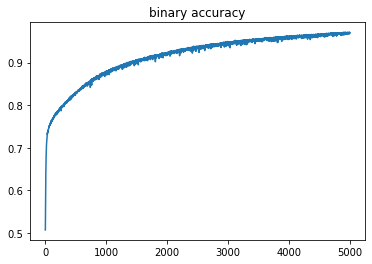

In [17]:
plt.plot(trans.history_['binary_accuracy'])
plt.title('binary accuracy');

In [18]:
train_shapelets = trans.transform(train_X)
valid_shapelets = trans.transform(valid_X)
test_shapelets = trans.transform(df_test_3d)

41/41 - 3s
11/11 - 0s
24/24 - 0s


In [19]:
train_shapelets.shape

(20774, 24)

In [20]:
#saving this for the next stage
np.save('train_transformed', train_shapelets)
np.save('valid_transformed', valid_shapelets)
np.save('test_transformed', test_shapelets)

np.save('train_y', train_y)
np.save('valid_y', valid_y)

## Modeling

In [21]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [22]:
# model = lgbm.LGBMClassifier(n_estimators=2500, num_leaves=35, min_child_samples=150,
#                             reg_lambda=0.1, colsample_bytree=0.95, random_state=8)
model = lgbm.LGBMClassifier(n_estimators = 2500, random_state=8)
model.fit(train_shapelets, train_y, eval_set=[(valid_shapelets, valid_y)], eval_metric='AUC')

[1]	valid_0's auc: 0.721915	valid_0's binary_logloss: 0.674742
[2]	valid_0's auc: 0.733843	valid_0's binary_logloss: 0.659867
[3]	valid_0's auc: 0.744247	valid_0's binary_logloss: 0.64682
[4]	valid_0's auc: 0.752225	valid_0's binary_logloss: 0.635812
[5]	valid_0's auc: 0.753706	valid_0's binary_logloss: 0.626508
[6]	valid_0's auc: 0.754624	valid_0's binary_logloss: 0.618798
[7]	valid_0's auc: 0.754657	valid_0's binary_logloss: 0.612723
[8]	valid_0's auc: 0.755254	valid_0's binary_logloss: 0.60728
[9]	valid_0's auc: 0.757173	valid_0's binary_logloss: 0.602048
[10]	valid_0's auc: 0.758985	valid_0's binary_logloss: 0.597409
[11]	valid_0's auc: 0.760729	valid_0's binary_logloss: 0.593033
[12]	valid_0's auc: 0.761375	valid_0's binary_logloss: 0.589455
[13]	valid_0's auc: 0.763054	valid_0's binary_logloss: 0.585988
[14]	valid_0's auc: 0.76409	valid_0's binary_logloss: 0.583153
[15]	valid_0's auc: 0.764946	valid_0's binary_logloss: 0.580567
[16]	valid_0's auc: 0.765194	valid_0's binary_loglos

LGBMClassifier(n_estimators=2500, random_state=8)

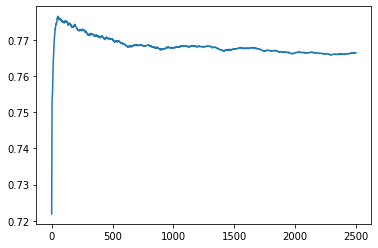

In [23]:
plt.plot(model.evals_result_['valid_0']['auc']);

### Let's try to train shapelets with only 1000 iterations

In [24]:
random.seed(99)
# we're taking only 30% of the train dataset
PERCENTAGE = 0.3
train_sequence_we_want = random.sample(set(trainid), k=int(PERCENTAGE*len(trainid)))

# but the 3D train dataset is in ndarray, so there must be some sequence numbers which are bigger than the 3D matrix size
# so, we need to take True and False for each data
train_or_no = np.isin(trainid, train_sequence_we_want)


# make the shapelet learner class and fit
trans = LearningShapelets(weight_regularizer=0.003, batch_size=512, max_iter=1000, total_lengths=5,
                          optimizer='Adam', scale=True, verbose=2)

print(datetime.datetime.now().time())
trans.fit(train_X[train_or_no, :, :], train_y[train_or_no])
print(datetime.datetime.now().time())

07:29:13.991320
Epoch 1/1000
13/13 - 16s - loss: 0.7127 - binary_accuracy: 0.4933 - binary_crossentropy: 0.7070
Epoch 2/1000
13/13 - 0s - loss: 0.6902 - binary_accuracy: 0.5834 - binary_crossentropy: 0.6845
Epoch 3/1000
13/13 - 0s - loss: 0.6783 - binary_accuracy: 0.5974 - binary_crossentropy: 0.6725
Epoch 4/1000
13/13 - 0s - loss: 0.6722 - binary_accuracy: 0.5618 - binary_crossentropy: 0.6664
Epoch 5/1000
13/13 - 0s - loss: 0.6675 - binary_accuracy: 0.5693 - binary_crossentropy: 0.6617
Epoch 6/1000
13/13 - 0s - loss: 0.6633 - binary_accuracy: 0.5871 - binary_crossentropy: 0.6574
Epoch 7/1000
13/13 - 0s - loss: 0.6594 - binary_accuracy: 0.6059 - binary_crossentropy: 0.6535
Epoch 8/1000
13/13 - 0s - loss: 0.6557 - binary_accuracy: 0.6253 - binary_crossentropy: 0.6498
Epoch 9/1000
13/13 - 0s - loss: 0.6521 - binary_accuracy: 0.6341 - binary_crossentropy: 0.6462
Epoch 10/1000
13/13 - 0s - loss: 0.6486 - binary_accuracy: 0.6427 - binary_crossentropy: 0.6427
Epoch 11/1000
13/13 - 0s - loss:

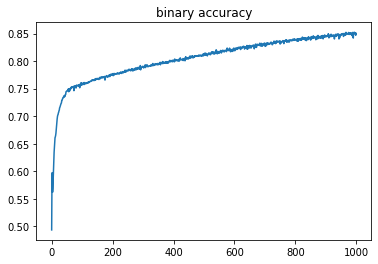

In [25]:
plt.plot(trans.history_['binary_accuracy'])
plt.title('binary accuracy');

In [26]:
train_shapelets = trans.transform(train_X)
valid_shapelets = trans.transform(valid_X)
test_shapelets = trans.transform(df_test_3d)

41/41 - 3s
11/11 - 0s
24/24 - 0s


In [27]:
# model = lgbm.LGBMClassifier(n_estimators=2500, num_leaves=35, min_child_samples=150,
#                             reg_lambda=0.1, colsample_bytree=0.95, random_state=8)
model = lgbm.LGBMClassifier(n_estimators = 2500, random_state=8)
model.fit(train_shapelets, train_y, eval_set=[(valid_shapelets, valid_y)], eval_metric='AUC')

[1]	valid_0's auc: 0.752065	valid_0's binary_logloss: 0.670479
[2]	valid_0's auc: 0.762694	valid_0's binary_logloss: 0.651796
[3]	valid_0's auc: 0.768031	valid_0's binary_logloss: 0.636159
[4]	valid_0's auc: 0.76986	valid_0's binary_logloss: 0.623533
[5]	valid_0's auc: 0.773345	valid_0's binary_logloss: 0.612131
[6]	valid_0's auc: 0.775586	valid_0's binary_logloss: 0.602477
[7]	valid_0's auc: 0.777887	valid_0's binary_logloss: 0.594171
[8]	valid_0's auc: 0.779204	valid_0's binary_logloss: 0.587032
[9]	valid_0's auc: 0.78073	valid_0's binary_logloss: 0.580896
[10]	valid_0's auc: 0.78189	valid_0's binary_logloss: 0.575472
[11]	valid_0's auc: 0.783006	valid_0's binary_logloss: 0.570963
[12]	valid_0's auc: 0.783799	valid_0's binary_logloss: 0.566988
[13]	valid_0's auc: 0.784471	valid_0's binary_logloss: 0.563731
[14]	valid_0's auc: 0.785838	valid_0's binary_logloss: 0.560311
[15]	valid_0's auc: 0.786597	valid_0's binary_logloss: 0.557704
[16]	valid_0's auc: 0.78787	valid_0's binary_logloss

LGBMClassifier(n_estimators=2500, random_state=8)

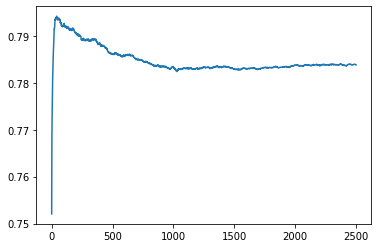

In [28]:
plt.plot(model.evals_result_['valid_0']['auc']);

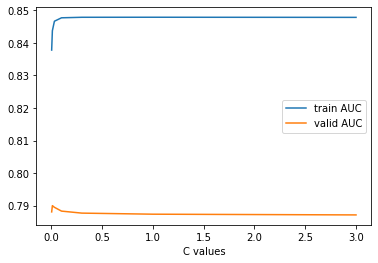

In [29]:
train_AUCs_logistic = []
valid_AUCs_logistic = []
cvals = [3, 1, 0.3, 0.1, 0.03, 0.01, 0.003]

for c in cvals:
    logistic_model = LogisticRegression(C=c, max_iter=1000, random_state=9)
    logistic_model.fit(train_shapelets, train_y)

    train_AUCs_logistic.append(roc_auc_score(train_y, logistic_model.predict_proba(train_shapelets)[:,1]))
    valid_AUCs_logistic.append(roc_auc_score(valid_y, logistic_model.predict_proba(valid_shapelets)[:,1]))
    
plt.plot(cvals, train_AUCs_logistic, label='train AUC')
plt.plot(cvals, valid_AUCs_logistic, label='valid AUC')
plt.legend()
plt.xlabel('C values');

## Neural Networks

### Using transformed data earlier

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC'])

history = model.fit(x=train_shapelets, y=train_y, epochs=500, batch_size=32,
                    validation_data=(valid_shapelets, valid_y))

Epoch 1/500
650/650 [==============================] - 3s 4ms/step - loss: 0.6840 - auc: 0.6039 - val_loss: 0.6592 - val_auc: 0.7734
Epoch 2/500
650/650 [==============================] - 2s 3ms/step - loss: 0.6228 - auc: 0.7776 - val_loss: 0.6081 - val_auc: 0.7816
Epoch 3/500
650/650 [==============================] - 2s 3ms/step - loss: 0.5677 - auc: 0.8078 - val_loss: 0.5739 - val_auc: 0.7857
Epoch 4/500
650/650 [==============================] - 2s 3ms/step - loss: 0.5377 - auc: 0.8167 - val_loss: 0.5632 - val_auc: 0.7869
Epoch 5/500
650/650 [==============================] - 2s 3ms/step - loss: 0.5199 - auc: 0.8249 - val_loss: 0.5557 - val_auc: 0.7880
Epoch 6/500
650/650 [==============================] - 2s 3ms/step - loss: 0.5145 - auc: 0.8245 - val_loss: 0.5553 - val_auc: 0.7886
Epoch 7/500
650/650 [==============================] - 2s 4ms/step - loss: 0.5113 - auc: 0.8257 - val_loss: 0.6187 - val_auc: 0.7893
Epoch 8/500
650/650 [==============================] - 2s 3ms/step - 

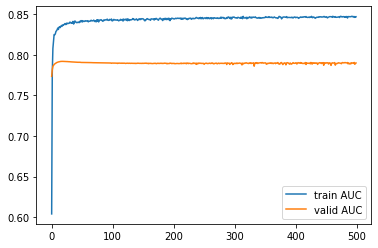

In [31]:
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='valid AUC')
plt.legend();

### Using LSTM

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC'])

history = model.fit(x=train_X, y=train_y, epochs=100, batch_size=32,
                    validation_data=(valid_X, valid_y), verbose=2)

Epoch 1/100
650/650 - 6s - loss: 0.6684 - auc: 0.6206 - val_loss: 0.6457 - val_auc: 0.6656
Epoch 2/100
650/650 - 4s - loss: 0.6162 - auc: 0.7150 - val_loss: 0.6107 - val_auc: 0.7309
Epoch 3/100
650/650 - 4s - loss: 0.5634 - auc: 0.7779 - val_loss: 0.5875 - val_auc: 0.7726
Epoch 4/100
650/650 - 4s - loss: 0.5207 - auc: 0.8162 - val_loss: 0.5326 - val_auc: 0.8116
Epoch 5/100
650/650 - 3s - loss: 0.4799 - auc: 0.8485 - val_loss: 0.5068 - val_auc: 0.8280
Epoch 6/100
650/650 - 4s - loss: 0.4536 - auc: 0.8668 - val_loss: 0.4946 - val_auc: 0.8379
Epoch 7/100
650/650 - 3s - loss: 0.4297 - auc: 0.8820 - val_loss: 0.5010 - val_auc: 0.8431
Epoch 8/100
650/650 - 3s - loss: 0.4086 - auc: 0.8941 - val_loss: 0.4789 - val_auc: 0.8566
Epoch 9/100
650/650 - 3s - loss: 0.3896 - auc: 0.9045 - val_loss: 0.4986 - val_auc: 0.8660
Epoch 10/100
650/650 - 3s - loss: 0.3764 - auc: 0.9113 - val_loss: 0.4548 - val_auc: 0.8733
Epoch 11/100
650/650 - 4s - loss: 0.3592 - auc: 0.9198 - val_loss: 0.4470 - val_auc: 0.87

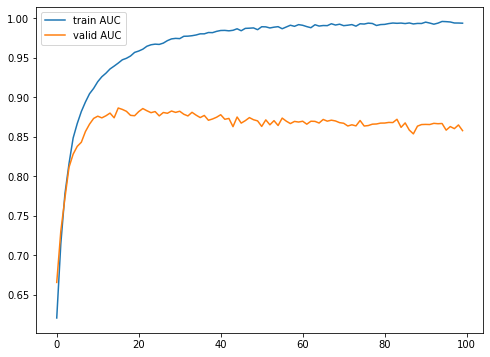

In [33]:
plt.figure(figsize=(8,6))
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='valid AUC')
plt.legend();

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC'])

history = model.fit(x=train_X, y=train_y, epochs=100, batch_size=32,
                    validation_data=(valid_X, valid_y), verbose=2)

Epoch 1/100
650/650 - 6s - loss: 0.6837 - auc: 0.5919 - val_loss: 0.6669 - val_auc: 0.6308
Epoch 2/100
650/650 - 4s - loss: 0.6488 - auc: 0.6650 - val_loss: 0.6361 - val_auc: 0.6803
Epoch 3/100
650/650 - 3s - loss: 0.6125 - auc: 0.7210 - val_loss: 0.5968 - val_auc: 0.7439
Epoch 4/100
650/650 - 4s - loss: 0.5664 - auc: 0.7757 - val_loss: 0.5574 - val_auc: 0.7856
Epoch 5/100
650/650 - 3s - loss: 0.5247 - auc: 0.8147 - val_loss: 0.5162 - val_auc: 0.8212
Epoch 6/100
650/650 - 3s - loss: 0.4912 - auc: 0.8415 - val_loss: 0.4977 - val_auc: 0.8367
Epoch 7/100
650/650 - 4s - loss: 0.4657 - auc: 0.8601 - val_loss: 0.4761 - val_auc: 0.8530
Epoch 8/100
650/650 - 4s - loss: 0.4465 - auc: 0.8727 - val_loss: 0.4735 - val_auc: 0.8584
Epoch 9/100
650/650 - 4s - loss: 0.4278 - auc: 0.8845 - val_loss: 0.4587 - val_auc: 0.8673
Epoch 10/100
650/650 - 3s - loss: 0.4146 - auc: 0.8919 - val_loss: 0.4625 - val_auc: 0.8684
Epoch 11/100
650/650 - 4s - loss: 0.4061 - auc: 0.8967 - val_loss: 0.4579 - val_auc: 0.86

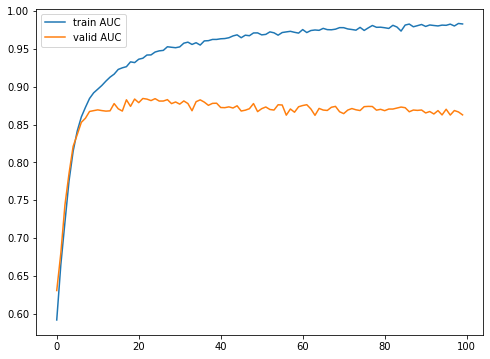

In [35]:
plt.figure(figsize=(8,6))
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='valid AUC')
plt.legend();

### LSTM for each sensor, then combine

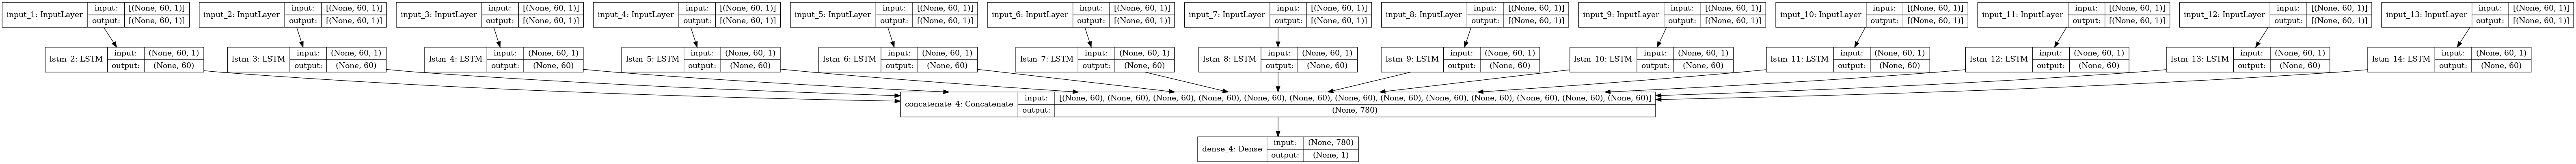

In [36]:
x1i = tf.keras.Input(shape=(60,1))
x2i = tf.keras.Input(shape=(60,1))
x3i = tf.keras.Input(shape=(60,1))
x4i = tf.keras.Input(shape=(60,1))
x5i = tf.keras.Input(shape=(60,1))
x6i = tf.keras.Input(shape=(60,1))
x7i = tf.keras.Input(shape=(60,1))
x8i = tf.keras.Input(shape=(60,1))
x9i = tf.keras.Input(shape=(60,1))
x10i = tf.keras.Input(shape=(60,1))
x11i = tf.keras.Input(shape=(60,1))
x12i = tf.keras.Input(shape=(60,1))
x13i = tf.keras.Input(shape=(60,1))

x1 = tf.keras.layers.LSTM(60)(x1i)
x2 = tf.keras.layers.LSTM(60)(x2i)
x3 = tf.keras.layers.LSTM(60)(x3i)
x4 = tf.keras.layers.LSTM(60)(x4i)
x5 = tf.keras.layers.LSTM(60)(x5i)
x6 = tf.keras.layers.LSTM(60)(x6i)
x7 = tf.keras.layers.LSTM(60)(x7i)
x8 = tf.keras.layers.LSTM(60)(x8i)
x9 = tf.keras.layers.LSTM(60)(x9i)
x10 = tf.keras.layers.LSTM(60)(x10i)
x11 = tf.keras.layers.LSTM(60)(x11i)
x12 = tf.keras.layers.LSTM(60)(x12i)
x13 = tf.keras.layers.LSTM(60)(x13i)

x_all = tf.keras.layers.Concatenate()([x1, x2, x3, x4, x5, x6,x7, x8, x9, x10, x11, x12, x13])
final = tf.keras.layers.Dense(1, activation='sigmoid')(x_all)

model = tf.keras.Model(inputs=[x1i, x2i, x3i, x4i, x5i, x6i, x7i, x8i, x9i, x10i, x11i, x12i, x13i], outputs=final)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC'])
tf.keras.utils.plot_model(model, 'LSTM_1by1.png', show_shapes=True)

In [37]:
history = model.fit([train_X[:, :, 0].reshape((20774, 60, 1)),
                     train_X[:, :, 1].reshape((20774, 60, 1)),
                     train_X[:, :, 2].reshape((20774, 60, 1)),
                     train_X[:, :, 3].reshape((20774, 60, 1)),
                     train_X[:, :, 4].reshape((20774, 60, 1)),
                     train_X[:, :, 5].reshape((20774, 60, 1)),
                     train_X[:, :, 6].reshape((20774, 60, 1)),
                     train_X[:, :, 7].reshape((20774, 60, 1)),
                     train_X[:, :, 8].reshape((20774, 60, 1)),
                     train_X[:, :, 9].reshape((20774, 60, 1)),
                     train_X[:, :, 10].reshape((20774, 60, 1)),
                     train_X[:, :, 11].reshape((20774, 60, 1)),
                     train_X[:, :, 12].reshape((20774, 60, 1))], train_y, epochs=100, batch_size=32, verbose=2,
                    validation_data=([valid_X[:, :, 0].reshape((5194, 60, 1)),
                                      valid_X[:, :, 1].reshape((5194, 60, 1)),
                                      valid_X[:, :, 2].reshape((5194, 60, 1)),
                                      valid_X[:, :, 3].reshape((5194, 60, 1)),
                                      valid_X[:, :, 4].reshape((5194, 60, 1)),
                                      valid_X[:, :, 5].reshape((5194, 60, 1)),
                                      valid_X[:, :, 6].reshape((5194, 60, 1)),
                                      valid_X[:, :, 7].reshape((5194, 60, 1)),
                                      valid_X[:, :, 8].reshape((5194, 60, 1)),
                                      valid_X[:, :, 9].reshape((5194, 60, 1)),
                                      valid_X[:, :, 10].reshape((5194, 60, 1)),
                                      valid_X[:, :, 11].reshape((5194, 60, 1)),
                                      valid_X[:, :, 12].reshape((5194, 60, 1))], valid_y))

Epoch 1/100
650/650 - 45s - loss: 0.6621 - auc: 0.6421 - val_loss: 0.6466 - val_auc: 0.6727
Epoch 2/100
650/650 - 25s - loss: 0.6169 - auc: 0.7204 - val_loss: 0.5970 - val_auc: 0.7573
Epoch 3/100
650/650 - 24s - loss: 0.5761 - auc: 0.7690 - val_loss: 0.5623 - val_auc: 0.7951
Epoch 4/100
650/650 - 25s - loss: 0.5613 - auc: 0.7837 - val_loss: 0.5232 - val_auc: 0.8186
Epoch 5/100
650/650 - 24s - loss: 0.5019 - auc: 0.8363 - val_loss: 0.4718 - val_auc: 0.8622
Epoch 6/100
650/650 - 26s - loss: 0.5109 - auc: 0.8305 - val_loss: 0.5191 - val_auc: 0.8287
Epoch 7/100
650/650 - 24s - loss: 0.4886 - auc: 0.8471 - val_loss: 0.4782 - val_auc: 0.8548
Epoch 8/100
650/650 - 24s - loss: 0.4514 - auc: 0.8719 - val_loss: 0.4383 - val_auc: 0.8864
Epoch 9/100
650/650 - 25s - loss: 0.4107 - auc: 0.8951 - val_loss: 0.3980 - val_auc: 0.9024
Epoch 10/100
650/650 - 24s - loss: 0.3790 - auc: 0.9113 - val_loss: 0.3582 - val_auc: 0.9222
Epoch 11/100
650/650 - 25s - loss: 0.3520 - auc: 0.9238 - val_loss: 0.3825 - va

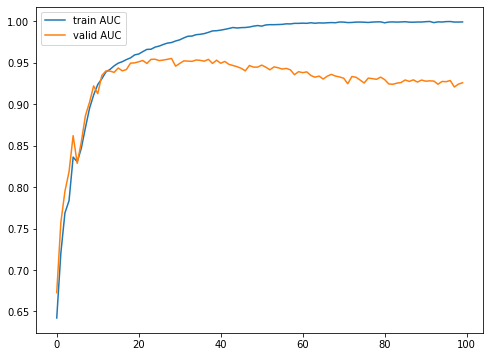

In [38]:
plt.figure(figsize=(8,6))
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='valid AUC')
plt.legend();

In [39]:
history = model.fit([train_X[:, :, 0].reshape((20774, 60, 1)),
                     train_X[:, :, 1].reshape((20774, 60, 1)),
                     train_X[:, :, 2].reshape((20774, 60, 1)),
                     train_X[:, :, 3].reshape((20774, 60, 1)),
                     train_X[:, :, 4].reshape((20774, 60, 1)),
                     train_X[:, :, 5].reshape((20774, 60, 1)),
                     train_X[:, :, 6].reshape((20774, 60, 1)),
                     train_X[:, :, 7].reshape((20774, 60, 1)),
                     train_X[:, :, 8].reshape((20774, 60, 1)),
                     train_X[:, :, 9].reshape((20774, 60, 1)),
                     train_X[:, :, 10].reshape((20774, 60, 1)),
                     train_X[:, :, 11].reshape((20774, 60, 1)),
                     train_X[:, :, 12].reshape((20774, 60, 1))], train_y, epochs=25, batch_size=32, verbose=0,
                    validation_data=([valid_X[:, :, 0].reshape((5194, 60, 1)),
                                      valid_X[:, :, 1].reshape((5194, 60, 1)),
                                      valid_X[:, :, 2].reshape((5194, 60, 1)),
                                      valid_X[:, :, 3].reshape((5194, 60, 1)),
                                      valid_X[:, :, 4].reshape((5194, 60, 1)),
                                      valid_X[:, :, 5].reshape((5194, 60, 1)),
                                      valid_X[:, :, 6].reshape((5194, 60, 1)),
                                      valid_X[:, :, 7].reshape((5194, 60, 1)),
                                      valid_X[:, :, 8].reshape((5194, 60, 1)),
                                      valid_X[:, :, 9].reshape((5194, 60, 1)),
                                      valid_X[:, :, 10].reshape((5194, 60, 1)),
                                      valid_X[:, :, 11].reshape((5194, 60, 1)),
                                      valid_X[:, :, 12].reshape((5194, 60, 1))], valid_y))

# Predict

In [40]:
subs = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv')
subs.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [41]:
subs['state'] = model.predict([df_test_3d[:, :, 0].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 1].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 2].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 3].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 4].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 5].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 6].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 7].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 8].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 9].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 10].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 11].reshape((12218, 60, 1)),
                               df_test_3d[:, :, 12].reshape((12218, 60, 1))])
subs.head()

,sequence,state
0,25968,2.745639e-01
1,25969,1.000000e+00
2,25970,2.527426e-13
3,25971,9.999994e-01
4,25972,9.420748e-01


In [42]:
subs.to_csv('submissions_LSTM.csv', index=False)